# Deep Learning Approaches for Image Denoising

#### Imad AOUALI and Abdellah RAHMANI

In this notebook, we have tried to test deep learning models and compare their performance to SinGAN. We have tried to change the noise level to see the advantages and limitations of these neural network and what SinGAN outperforms these models and in what singan is outperformed by these Neural networks. We are going to present quantitative and qualitative results. 

Most of the functions are taken from the tutorials of the Image denosing course realized by J.-M. MOREL, G.FACCIOLO, P.ARIAS.

For the pre-trained models, you can download them from the github of the above mentioned course: https://github.com/gfacciol/MVAdenoising 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/SinGAN

/content/drive/My Drive/SinGAN


In [ ]:
try:
    from google.colab import files
    !pip install hdf5storage

    !rm -fr MVAdenoising
    !git clone  https://github.com/gfacciol/MVAdenoising
    !cp -r MVAdenoising/* .

except ImportError:
    # %matplotlib notebook
    pass


# These are all the includes used through the notebook
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io # read and write images
import vistools        # image visualization toolbox

# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}
    
    
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 61kB 5.3MB/s 
Cloning into 'MVAdenoising'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 901 (delta 0), reused 0 (delta 0), pack-reused 897
Receiving objects: 100% (901/901), 262.38 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Checking out files: 100% (607/607), done.


In [ ]:
def PSNR(img1, img2, peak=255):
    '''
    Computes the PSNR 'metric' between two images assumed to be in the range [0,1]
    '''
    x = ((np.array(img1).squeeze() - np.array(img2).squeeze()).flatten() )
    return (10*np.log10(peak**2 / np.mean(x**2)))

In [ ]:
def test_denoiser(denoiser, img_in, sigma=30, show=False, has_noise=False):
    '''
    Helper function to test a denoising network.

    Args:
        denoiser: denoising network
        img_in: input image (either clean or noisy)
        sigma: noise standard deviation
        has_noise: set it to True if img_in is a noisy image.
                   set it to False if img_in is the clean image. In this
                   case noise will be added to test the denoising.
        show: if True shows a gallery with the denoising result

    Returns:
        img_denoised: denoised image
        img_noisy: noisy image
        psnr_out: psnr after denoising (only if has_noise == False)
        psnr_in: psnr before denoising (only if has_noise == False)
    '''

    # put the image in the range [0,1] and add noise
    if has_noise == False:
        img_clean = img_in.astype('float32') / 255.
        img_test = img_clean + np.random.normal(0, sigma/255.0, img_clean.shape)
    else:
        img_test = img_in.astype('float32') / 255.

    # call the denoiser

    # torch data type
    dtype = torch.FloatTensor
    if torch.cuda.is_available():
        # run on GPU
        denoiser = denoiser.cuda()
        dtype = torch.cuda.FloatTensor

    # set denoising network in evaluation (inference) mode
    denoiser.eval()

    # apply denoising network
    with torch.no_grad(): # tell pytorch that we don't need gradients
        img = dtype(img_test[np.newaxis,np.newaxis,:,:]) # convert to tensor
        out = denoiser.forward(img) # apply network; equivalent to out = denoiser(img)
        out = out.cpu() # move to CPU memory
        img = img.cpu()
    # compute psnr
    if has_noise == False:
        psnrIN, psnrOUT = PSNR(img_clean, img.cpu(), 1), PSNR(img_clean, out, 1)
    else:
        psnrIN, psnrOUT = -1, -1

    # scale outputs to [0,255]
    out *= 255.
    img *= 255.

    # visualize as gallery
    if show:
        if has_noise == False:
            vistools.display_gallery([np.array(img_clean).clip(0,1)*255,
                                      np.array(img).clip(0,255),
                                      np.array(out).clip(0,255)],
                                     ['clean', 'noisy (%.2f dB)'%psnrIN,
                                      'denoised (%.2f dB)'%psnrOUT])
        else:
            vistools.display_gallery([np.array(img).clip(0,255),
                                      np.array(out).clip(0,255)],                                      
                                     ['noisy', 'denoised'])

    return out, img, psnrOUT, psnrIN

# Qualitatif result for pretrained DnCNN(sigma = 30 and 50) :

### In this part, we tried to test the DnCNN on two different images and two noise levels.
##### Image 1 :

In [ ]:
# Read clean image 
img_clean = io.imread('Input/Images/book_gray.png').astype(np.float32)

In [ ]:
# Load pretrained model:
from models import DnCNN_pretrained 
dncnn_30 = DnCNN_pretrained(30)
dncnn_50 = DnCNN_pretrained(50)


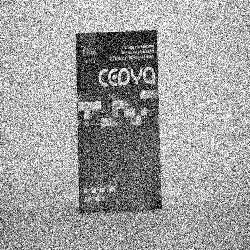
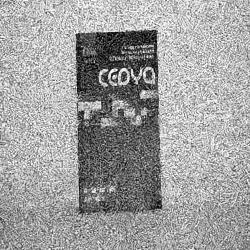

In [ ]:
img_noisy = img_clean + np.random.normal(0, 50, img_clean.shape)

out = test_denoiser(dncnn_30, img_noisy, None,show=True, has_noise=True)[0]


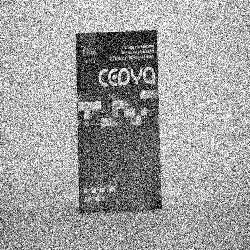
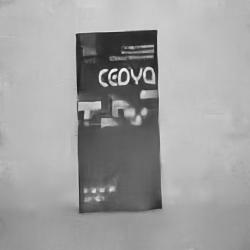

In [ ]:
out = test_denoiser(dncnn_50, img_noisy, None,show=True, has_noise=True)[0]

##### Image 2:

In [ ]:
img_clean = io.imread('Input/Images/singan2_deep.png').astype(np.float32)


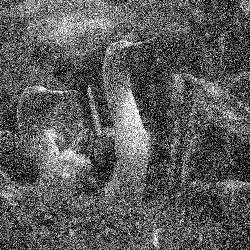
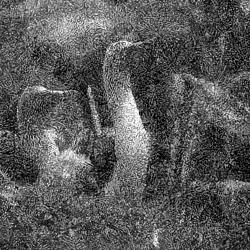

In [ ]:
img_noisy = img_clean + np.random.normal(0, 50, img_clean.shape)

out = test_denoiser(dncnn_30, img_noisy, None,show=True, has_noise=True)[0]


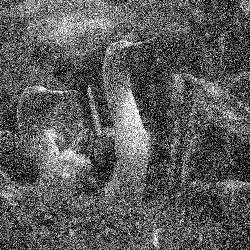
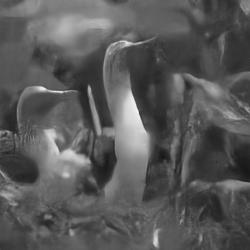

In [ ]:
out = test_denoiser(dncnn_50, img_noisy, None,show=True, has_noise=True)[0]

# Comparison between the different models used (BM3D, SinGAN, DnCNN, Blind DnCNN), testing them on different noise levels:

In [ ]:
from models import DnCNN_pretrained 
# choose the base directory for the trainings 
basedir='pre-trained-tp2'
#basedir=persistent_storage

# Read clean image
img_clean = io.imread('Input/Images/book_gray.png').astype(np.float32)

# load blind networks
hdncnn = torch.load(basedir+'/blind_half_DnCNN_3000.pt')[0]

# initialize lists for storing the psnrs
sigmas=[]
psnrs_hdncnn=[]
psnrs_dncnn=[]
psnrs_dncnn_better = []
dncnn = DnCNN_pretrained(30)
for sigma in range(10,75,5):

    img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

    # half DnCNN
    out = test_denoiser(hdncnn, img_noisy, None, has_noise=True)[0]
    psnrs_hdncnn.append( PSNR(out, img_clean) )

    # result of full DnCNN with trained weights using sigma =30
    out = test_denoiser(dncnn, img_noisy, None, has_noise=True)[0]
    psnrs_dncnn.append( PSNR(out, img_clean) )
    # result of full DnCNN with trained weights for different value of sigma
    dncnn_better = DnCNN_pretrained(sigma)
    out = test_denoiser(dncnn_better, img_noisy, None, has_noise=True)[0]
    psnrs_dncnn_better.append( PSNR(out, img_clean) )

    sigmas.append(sigma)



In [ ]:
# value of PSNR for singan (in the other notebook) and BM3D(using Ipol)
singan = [34.64,34.12,33.75,32.84,32.39,31.5,30.92,30.16,29.43,29.08,28.96,28.16,27.77]
bm3d = [36.2753, 34.6353, 33.3574, 32.4448, 31.4654, 30.9017, 30.2623, 29.7356, 29.0693, 28.6599, 28.3985, 27.9494, 27.6154]

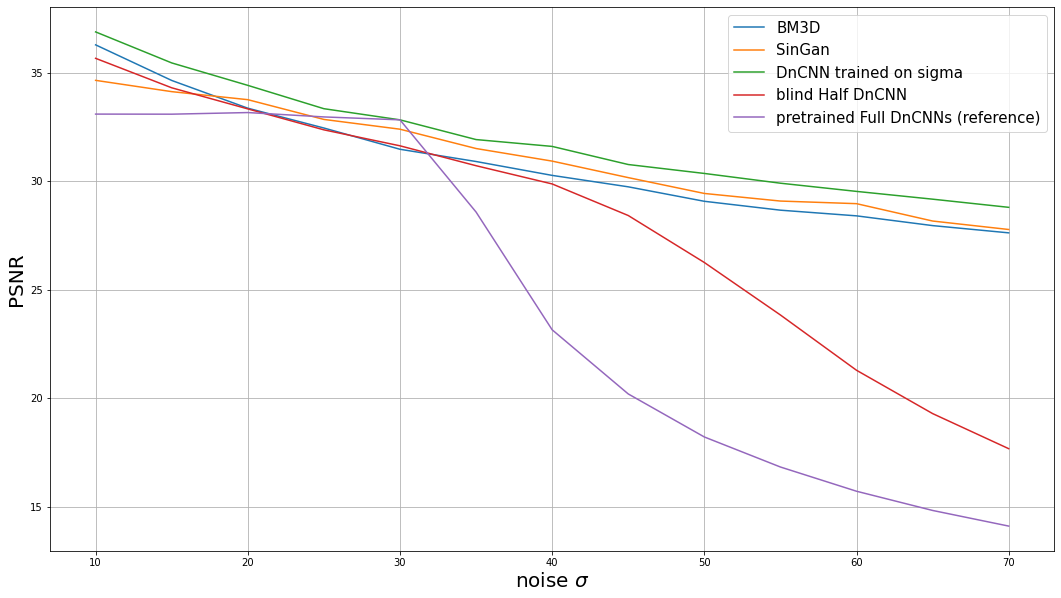

In [ ]:
# plot results
plt.figure(figsize=(18,10))
plt.plot(sigmas,bm3d, label='BM3D')
plt.plot(sigmas,singan, label='SinGan')
plt.plot(sigmas,psnrs_dncnn_better, label ='DnCNN trained on sigma')
plt.plot(sigmas,psnrs_hdncnn   , label='blind Half DnCNN')
plt.plot(sigmas,psnrs_dncnn    , label='pretrained Full DnCNNs (reference)')
plt.xlabel('noise $\sigma$',fontsize = 20)
plt.ylabel('PSNR',fontsize = 20)
plt.grid()
plt.legend(prop={'size': 15})


# The impact of the loss used on the results of our DnCNN model: 

In [ ]:
# Read image and add noise 
p=0.4
im_clean = io.imread('Input/Images/singan2_deep.png').astype(np.float32)
mask = np.random.binomial(1, 1-p, im_clean.shape)
noise = np.random.uniform(0, 255., im_clean.shape)
im_noisy = im_clean * mask + noise * (1 - mask)

In [ ]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


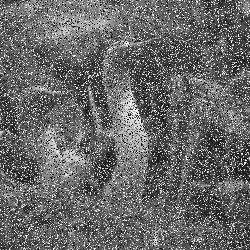
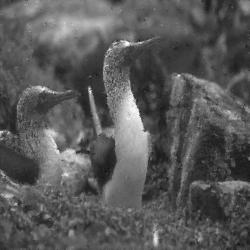

In [ ]:
# DnCNN pretrained using salt and pepper noise and l1 loss
net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_usp_2000.pt' , map_location=map_location)[0]
out = test_denoiser(net, im_noisy, None, show= True,has_noise=True)[0]

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


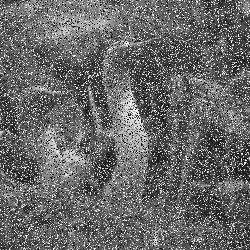
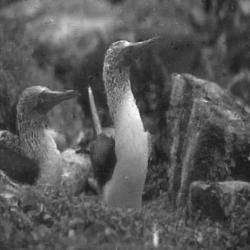

In [ ]:
# DnCNN pretrained using salt and pepper noise and l2 loss
net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_usp_2000.pt' , map_location=map_location)[0]
out = test_denoiser(net, im_noisy, None,show= True ,has_noise=True)[0]

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


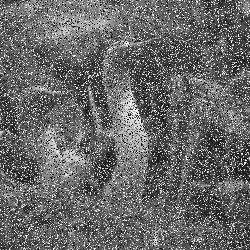
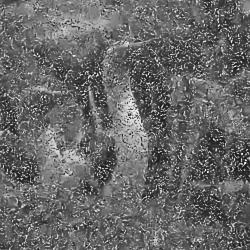

In [ ]:
# DnCNN pretrained using sGaussian noise and l2 loss
net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_2000.pt' , map_location=map_location)[0]
out = test_denoiser(net, im_noisy, None, show= True,has_noise=True)[0]